In [1]:
import os
import time
import datetime
from typing import Literal, Optional

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import numpy as np 
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
from chainconsumer import Chain, ChainConsumer, Truth
from tensorflow_probability.substrates.jax.distributions import Distribution

from configs import (
    cumulants_config, get_results_dir, get_posteriors_dir, 
    get_cumulants_sbi_args, get_ndes_from_config
)
from cumulants import (
    Dataset, get_data, get_prior, 
    get_compression_fn, get_datavector, get_linearised_data
)

from sbiax.utils import make_df, marker
from sbiax.ndes import Scaler, Ensemble, CNF, MAF 
from sbiax.train import train_ensemble
from sbiax.inference import nuts_sample

from affine import affine_sample
from utils import plot_moments, plot_latin_moments, plot_summaries, plot_fisher_summaries

/Users/Jed.Homer/phd/sbiaxpdf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config

In [2]:
def cumulants_config(
    seed: int = 0, 
    redshift: float = 0., 
    reduced_cumulants: bool = False,
    sbi_type: Literal["nle", "npe"] = "nle", 
    linearised: bool = True, 
    compression: Literal["linear", "nn"] = "linear",
    order_idx: list[int] = [0, 1, 2],
    # nonlinearised: bool = True, 
    n_linear_sims: Optional[int] = None,
    pre_train: bool = False
) -> ConfigDict:

    config = ConfigDict()

    config.seed               = seed # For argparse script running without args!

    # Data
    config.dataset_name       = "reduced cumulants" if reduced_cumulants else "cumulants" 
    config.redshift           = redshift
    config.scales             = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]
    config.order_idx          = order_idx # Maximum index is 2
    config.compression        = compression
    config.linearised         = linearised
    config.covariance_epsilon = None # 1e-6
    config.reduced_cumulants  = reduced_cumulants
    config.pre_train          = pre_train and (not linearised)
    config.n_linear_sims      = n_linear_sims # This is for pre-train or linearised simulations 
    config.use_expectation    = False # Noiseless datavector
    config.valid_fraction     = 0.1

    # Miscallaneous
    config.use_scalers        = True # Input scalers for (xi, pi) in NDEs (NOTE: checked that scalings aren't optimised!)
    config.use_pca            = False # Need to add this into other scripts...
    config.ema_rate           = 0.995
    config.use_ema            = False # Use it and sample with it

    # SBI
    config.sbi_type           = sbi_type

    # Experiments
    config.exp_name           = "z={}_m={}".format(config.redshift, "".join(map(str, config.order_idx)))

    # Posterior sampling
    config.n_steps            = 200
    config.n_walkers          = 1000
    config.burn               = int(0.1 * config.n_steps)

    if config.linearised:
        # NDEs
        config.cnf = cnf = ConfigDict()
        cnf.model_type       = "cnf"
        cnf.width_size       = 8
        cnf.depth            = 0
        cnf.activation       = "tanh"
        cnf.dropout_rate     = 0.
        cnf.dt               = 0.1
        cnf.t1               = 1.
        cnf.solver           = "Euler" 
        cnf.exact_log_prob   = True
        cnf.use_scaling      = True # Defaults to (mu, std) of (x, y)

        config.maf = maf = ConfigDict()
        maf.model_type       = "maf" # = model.__class__.__name__
        maf.width_size       = 32
        maf.n_layers         = 2
        maf.nn_depth         = 2
        maf.activation       = "tanh"
        maf.use_scaling      = True # Defaults to (mu, std) of (x, y)

        config.ndes          = [cnf]#, cnf, cnf]  
        config.n_ndes        = len(config.ndes)

        # Optimisation hyperparameters (same for all NDEs...)
        config.train = train = ConfigDict()
        train.start_step     = 0
        train.n_epochs       = 10_000
        train.n_batch        = 100 
        train.patience       = 100
        train.lr             = 1e-3
        train.opt            = "adam" 
        train.opt_kwargs     = {}
    else:
        # NDEs
        config.cnf = cnf = ConfigDict()
        cnf.model_type       = "cnf"
        cnf.width_size       = 8 
        cnf.depth            = 0
        cnf.activation       = "tanh"
        cnf.dropout_rate     = 0.
        cnf.dt               = 0.1
        cnf.t1               = 1.
        cnf.solver           = "Euler"
        cnf.exact_log_prob   = True
        cnf.use_scaling      = True # Defaults to (mu, std) of (x, y)

        config.maf = maf = ConfigDict()
        maf.model_type       = "maf" # = model.__class__.__name__
        maf.width_size       = 32
        maf.n_layers         = 8
        maf.nn_depth         = 2
        maf.activation       = "tanh"
        maf.use_scaling      = True # Defaults to (mu, std) of (x, y)

        config.ndes          = [cnf]#, cnf, cnf] #maf, maf, maf]  
        config.n_ndes        = len(config.ndes)

        # Optimisation hyperparameters (same for all NDEs...)
        config.pretrain = pretrain = ConfigDict()
        pretrain.start_step  = 0
        pretrain.n_epochs    = 10_000
        pretrain.n_batch     = 100 
        pretrain.patience    = 10
        pretrain.lr          = 1e-3
        pretrain.opt         = "adam" 
        pretrain.opt_kwargs  = {}

        config.train = train = ConfigDict()
        train.start_step     = 0
        train.n_epochs       = 10_000
        train.n_batch        = 100 
        train.patience       = 10
        train.lr             = 1e-3
        train.opt            = "adam" 
        train.opt_kwargs     = {}

    return config

In [3]:
t0 = time.time()

args = ConfigDict()
args.seed                = 0
args.redshift            = 0.
args.sbi_type            = "nle"
args.linearised          = False 
args.reduced_cumulants   = True
args.compression         = "linear"
args.order_idx           = [0]
args.pre_train           = True and (not args.linearised)
args.n_linear_sims       = 10_000 #if args.linearised else 10_000

print("TIME:", datetime.datetime.now().strftime("%H:%M %d-%m-%y"))

config = cumulants_config(**args)

args.verbose             = False
args.use_tqdm            = True

print(args, config)

key = jr.key(config.seed)

( 
    model_key, train_key, key_prior, 
    key_datavector, key_state, key_sample
) = jr.split(key, 6)

results_dir = get_results_dir(config, args)

posteriors_dir = get_posteriors_dir(config)

# Dataset of simulations, parameters, covariance, ...
dataset: Dataset = get_data(config, verbose=args.verbose, results_dir=results_dir)

print("DATA:", ["{:.3E} {:.3E}".format(_.min(), _.max()) for _ in (dataset.fiducial_data, dataset.data)])
print("DATA:", [_.shape for _ in (dataset.fiducial_data, dataset.data)])

parameter_prior: Distribution = get_prior(config)

TIME: 16:53 13-03-25
compression: linear
linearised: false
n_linear_sims: 10000
order_idx:
- 0
pre_train: true
redshift: 0.0
reduced_cumulants: true
sbi_type: nle
seed: 0
use_tqdm: true
verbose: false
 burn: 20
cnf:
  activation: tanh
  depth: 0
  dropout_rate: 0.0
  dt: 0.1
  exact_log_prob: true
  model_type: cnf
  solver: Euler
  t1: 1.0
  use_scaling: true
  width_size: 8
compression: linear
covariance_epsilon: null
dataset_name: reduced cumulants
ema_rate: 0.995
exp_name: z=0.0_m=0
linearised: false
maf:
  activation: tanh
  model_type: maf
  n_layers: 8
  nn_depth: 2
  use_scaling: true
  width_size: 32
n_linear_sims: 10000
n_ndes: 1
n_steps: 200
n_walkers: 1000
ndes:
- !!python/object:ml_collections.config_dict.config_dict.ConfigDict
  _convert_dict: true
  _fields:
    activation: tanh
    depth: 0
    dropout_rate: 0.0
    dt: 0.1
    exact_log_prob: true
    model_type: cnf
    solver: Euler
    t1: 1.0
    use_scaling: true
    width_size: 8
  _locked: false
  _type_safe: tr

Compression

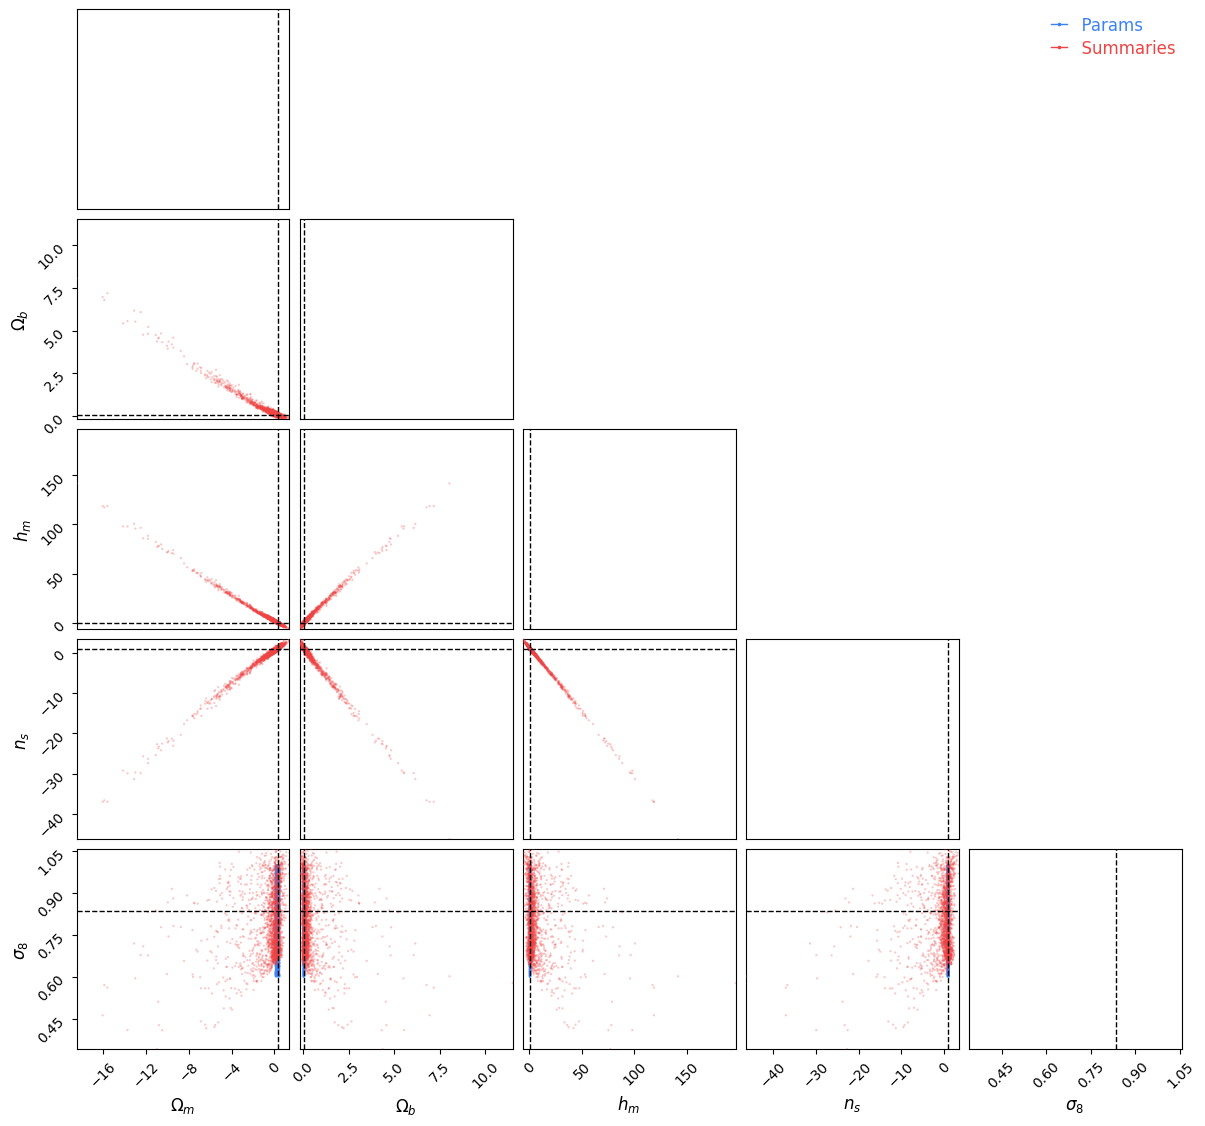

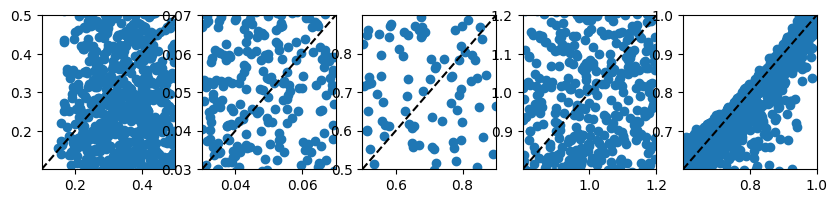

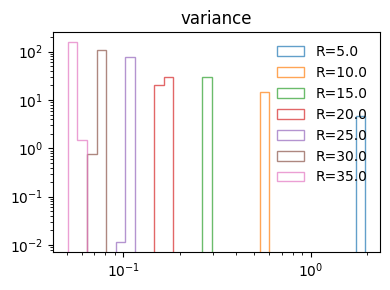

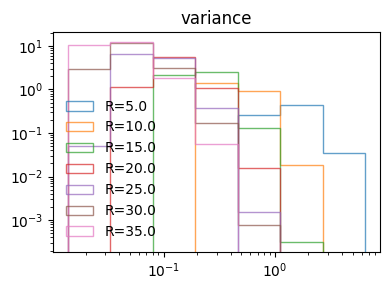

In [4]:
# Compress simulations
compression_fn = get_compression_fn(key, config, dataset, results_dir=results_dir)

X = jax.vmap(compression_fn)(dataset.data, dataset.parameters)

# Plot summaries
plot_summaries(X, dataset.parameters, dataset)

plot_moments(dataset.fiducial_data, config)

plot_latin_moments(dataset.data, config)

NDEs

In [5]:
def replace_scalers(ensemble, *, X, P):
    is_scaler = lambda x: isinstance(x, Scaler)
    get_scalers = lambda m: [
        x
        for x in jax.tree.leaves(m, is_leaf=is_scaler)
        if is_scaler(x)
    ]
    ensemble = eqx.tree_at(
        get_scalers, 
        ensemble, 
        [Scaler(X, P)] * sum(int(nde.use_scaling) for nde in config.ndes) 
    )
    return ensemble

In [6]:
scaler = Scaler(X, dataset.parameters, use_scaling=config.use_scalers)

ndes = get_ndes_from_config(
    config, 
    event_dim=dataset.alpha.size, 
    scalers=scaler, # Same scaler for all NDEs 
    use_scalers=config.use_scalers,
    key=model_key
)

# print("scaler:", ndes[0].scaler.mu_x if ndes[0].scaler is not None else None)

ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

data_preprocess_fn = lambda x: x #jnp.log(jnp.clip(x, min=1e-10))

Linearised pre-training...
Hypercube sampling...
Get linearised data (10000, 7) (10000, 5)
Pre-training with (10000, 7) (10000, 5) (10000, 5)
NDE has n_params=115.


Training terminated early at epoch 109; valid=-8.104E+00, train=-8.169E+00.:   1%|          | 108/10000 [00:31<48:47,  3.38epoch/s, t=-8.169E+00 | v=-8.104E+00 | v(best)=-8.156E+00 | stop=0000]


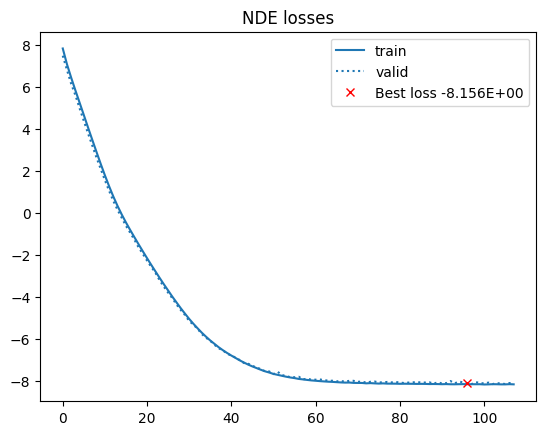

Weights: [1.]


Sampling: 100%|██████████| 220/220 [01:01<00:00,  3.57it/s]


In [7]:
# Only pre-train if required and not inferring from linear simulations
if (
    (not config.linearised) 
    and config.pre_train 
    and (config.n_linear_sims is not None)
):
    print("Linearised pre-training...")

    pre_train_key, summaries_key = jr.split(key)

    # Pre-train data = linearised simulations
    D_l, Y_l = get_linearised_data(config)

    X_l = jax.vmap(compression_fn)(D_l, Y_l)

    print("Pre-training with", D_l.shape, X_l.shape, Y_l.shape)

    plot_fisher_summaries(X_l, Y_l, dataset, results_dir)

    opt = getattr(optax, config.pretrain.opt)(config.pretrain.lr)

    if config.use_scalers:
        ensemble = replace_scalers(ensemble, X=X_l, P=dataset.parameters)

    ensemble, stats = train_ensemble(
        pre_train_key, 
        ensemble,
        train_mode=config.sbi_type,
        train_data=(data_preprocess_fn(X_l), Y_l), 
        opt=opt,
        use_ema=config.use_ema,
        ema_rate=config.ema_rate,
        n_batch=config.pretrain.n_batch,
        patience=config.pretrain.patience,
        n_epochs=config.pretrain.n_epochs,
        valid_fraction=config.valid_fraction,
        tqdm_description="Training (pre-train)",
        show_tqdm=args.use_tqdm,
        # results_dir=results_dir
    )

    # datavector = get_datavector(key_datavector, config)

    # Test pre-training on a linearised datavector...
    datavector = jr.multivariate_normal(
        key, 
        jnp.mean(dataset.fiducial_data, axis=0), 
        dataset.C
    )

    x_ = compression_fn(datavector, dataset.alpha)

    log_prob_fn = ensemble.ensemble_log_prob_fn(data_preprocess_fn(x_), parameter_prior)

    state = jr.multivariate_normal(
        key_state, x_, dataset.Finv, (2 * config.n_walkers,)
    )

    samples, weights = affine_sample(
        key_sample, 
        log_prob=log_prob_fn,
        n_walkers=config.n_walkers, 
        n_steps=config.n_steps + config.burn, 
        burn=config.burn, 
        current_state=state,
        description="Sampling",
        show_tqdm=args.use_tqdm
    )

    samples_log_prob = jax.vmap(log_prob_fn)(samples)
    alpha_log_prob = log_prob_fn(jnp.asarray(dataset.alpha))

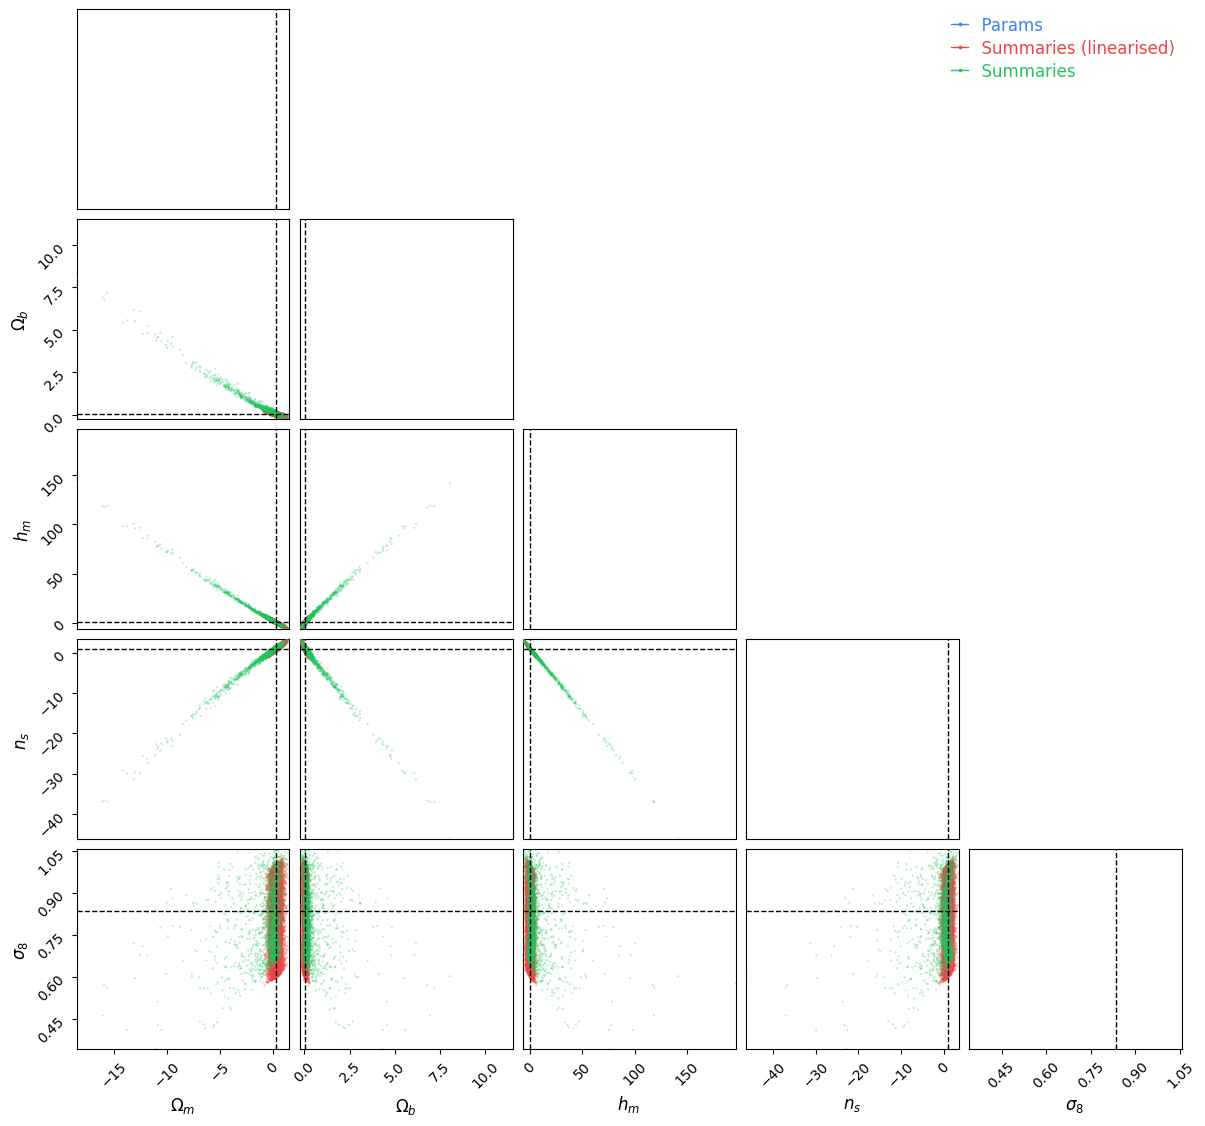

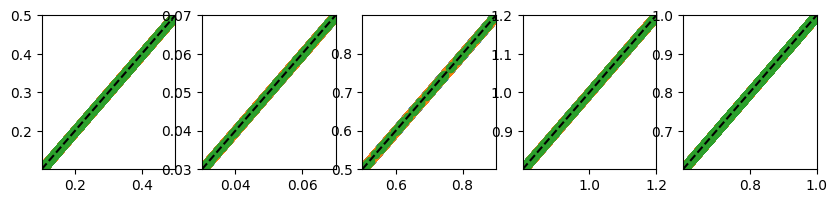

In [8]:
if (not args.linearised) and args.pre_train:
    c = ChainConsumer()
    c.add_chain(
        Chain(
            samples=make_df(dataset.parameters, parameter_strings=dataset.parameter_strings), 
            name="Params", 
            color="blue", 
            plot_cloud=True, 
            plot_contour=False
        )
    )
    c.add_chain(
        Chain(
            samples=make_df(X_l, parameter_strings=dataset.parameter_strings), 
            name="Summaries (linearised)", 
            color="red", 
            plot_cloud=True, 
            plot_contour=False
        )
    )
    c.add_chain(
        Chain(
            samples=make_df(X, parameter_strings=dataset.parameter_strings),
            name="Summaries", 
            color="green", 
            plot_cloud=True, 
            plot_contour=False
        )
    )
    c.add_truth(
        Truth(location=dict(zip(dataset.parameter_strings, dataset.alpha)), name=r"$\pi^0$")
    )
    fig = c.plotter.plot()
    plt.show()

    fig, axs = plt.subplots(1, dataset.alpha.size, figsize=(2. * dataset.alpha.size, 2.))
    for p, ax in enumerate(axs):
        ax.scatter(dataset.parameters[:, p], dataset.parameters[:, p])
        ax.scatter(X_l[:, p], X_l[:, p])
        ax.scatter(X[:, p], X[:, p])
        ax.axline((0, 0), slope=1., color="k", linestyle="--")
        ax.set_xlim(dataset.lower[p], dataset.upper[p])
        ax.set_ylim(dataset.lower[p], dataset.upper[p])
    plt.show()

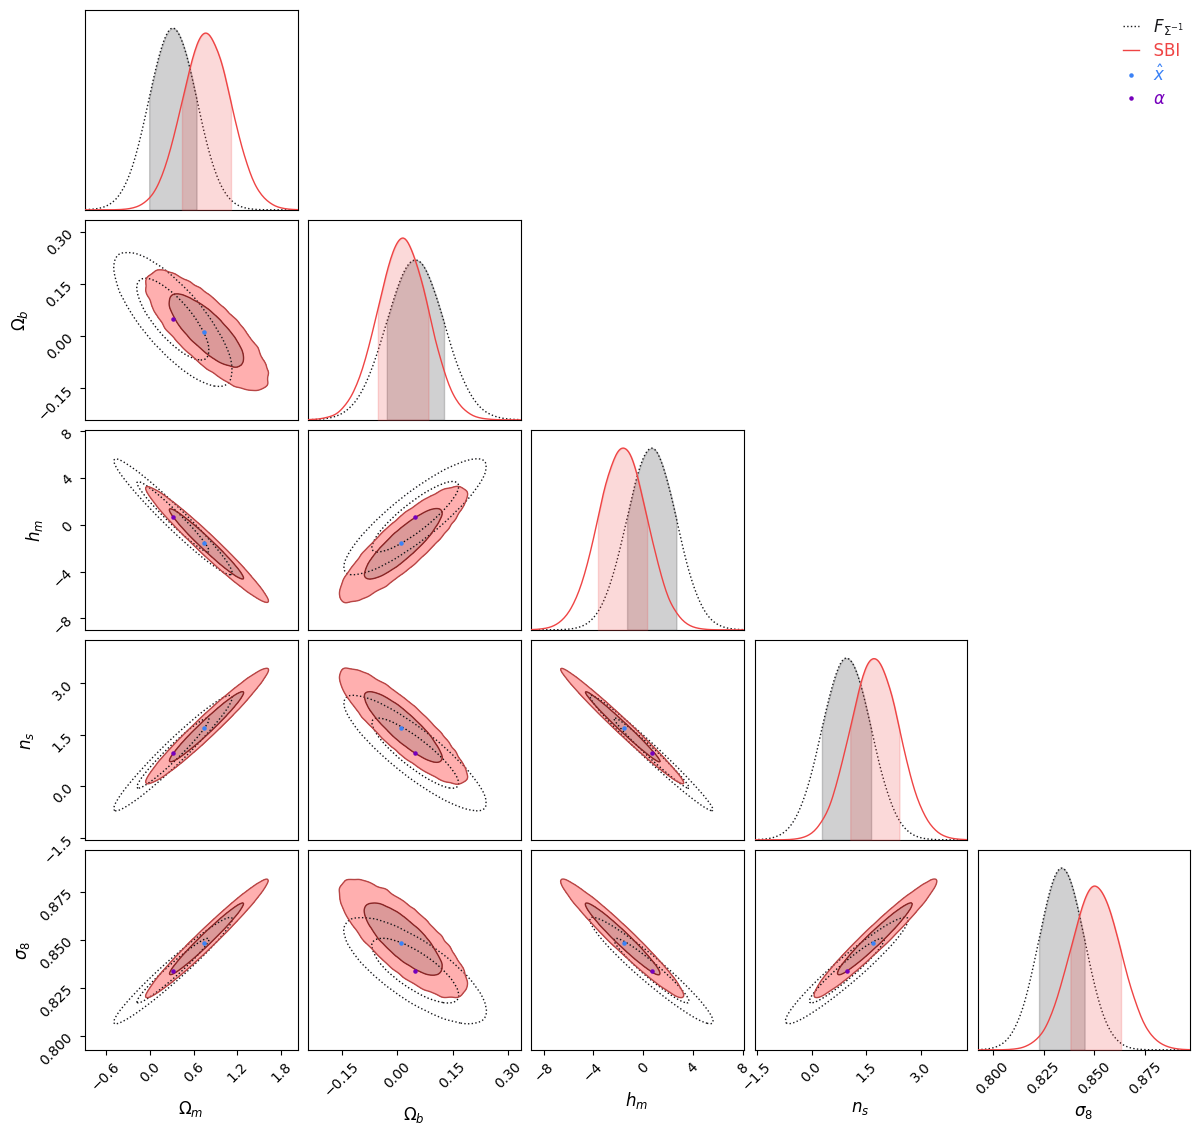

In [9]:
if (
    (not config.linearised) 
    and config.pre_train 
    and (config.n_linear_sims is not None)
):
    posterior_df = make_df(
        samples, 
        samples_log_prob, 
        parameter_strings=dataset.parameter_strings
    )

    np.savez(
        os.path.join(results_dir, "posterior.npz"), 
        alpha=dataset.alpha,
        samples=samples,
        samples_log_prob=samples_log_prob,
        datavector=datavector,
        summary=x_
    )

    c = ChainConsumer()
    c.add_chain(
        Chain.from_covariance(
            dataset.alpha,
            dataset.Finv,
            columns=dataset.parameter_strings,
            name=r"$F_{\Sigma^{-1}}$",
            color="k",
            linestyle=":",
            shade_alpha=0.
        )
    )
    c.add_chain(Chain(samples=posterior_df, name="SBI", color="r"))
    c.add_marker(
        location=marker(x_, parameter_strings=dataset.parameter_strings),
        name=r"$\hat{x}$", 
        color="b"
    )
    c.add_marker(
        location=marker(dataset.alpha, parameter_strings=dataset.parameter_strings),
        name=r"$\alpha$", 
        color="#7600bc"
    )
    fig = c.plotter.plot()
    plt.savefig(os.path.join(results_dir, "posterior_affine_pretrain.pdf"))
    plt.savefig(os.path.join(posteriors_dir, "posterior_affine_pretrain.pdf"))
    plt.show()

NDE on simulation

Data / Parameters [(2000, 5), (2000, 5)]
NDE has n_params=115.


Training terminated early at epoch 132; valid=-4.355E+00, train=-5.188E+00.:   1%|▏         | 131/10000 [00:08<10:19, 15.92epoch/s, t=-5.188E+00 | v=-4.355E+00 | v(best)=-4.789E+00 | stop=0000]


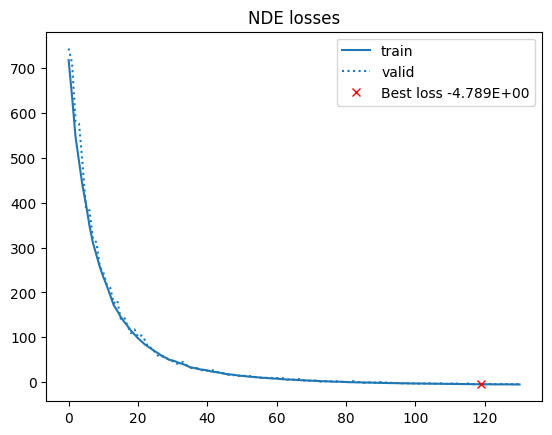

Weights: [1.]


In [10]:
opt = getattr(optax, config.train.opt)(config.train.lr)

print("Data / Parameters", [_.shape for _ in (X, dataset.parameters)])

if config.use_scalers:
    ensemble = replace_scalers(ensemble, X=X, P=dataset.parameters)

ensemble, stats = train_ensemble(
    train_key, 
    ensemble,
    train_mode=config.sbi_type,
    train_data=(data_preprocess_fn(X), dataset.parameters), 
    opt=opt,
    use_ema=config.use_ema,
    ema_rate=config.ema_rate,
    n_batch=config.train.n_batch,
    patience=config.train.patience,
    n_epochs=config.train.n_epochs,
    valid_fraction=config.valid_fraction,
    tqdm_description="Training (data)",
    show_tqdm=args.use_tqdm,
    # results_dir=results_dir
)

# print("scaler:", ndes[0].scaler.mu_x if ndes[0].scaler is not None else None)

In [11]:
ensemble = eqx.nn.inference_mode(ensemble)

# Generates linearised (or not) datavector at fiducial parameters
datavector = get_datavector(key_datavector, config)

x_ = compression_fn(datavector, dataset.alpha)

print("datavector", x_, dataset.alpha)

log_prob_fn = ensemble.ensemble_log_prob_fn(data_preprocess_fn(x_), parameter_prior)

state = jr.multivariate_normal(
    key_state, x_, dataset.Finv, (2 * config.n_walkers,)
)

samples, weights = affine_sample(
    key_sample, 
    log_prob=log_prob_fn,
    n_walkers=config.n_walkers, 
    n_steps=config.n_steps + config.burn, 
    burn=config.burn, 
    current_state=state,
    description="Sampling",
    show_tqdm=args.use_tqdm
)

samples_log_prob = jax.vmap(log_prob_fn)(samples)
alpha_log_prob = log_prob_fn(jnp.asarray(dataset.alpha))

np.savez(
    os.path.join(results_dir, "posterior.npz"), 
    alpha=dataset.alpha,
    samples=samples,
    samples_log_prob=samples_log_prob,
    datavector=datavector,
    summary=x_
)

Using non-linearised datavector
datavector [0.45803654 0.10679594 0.47452295 1.0135255  0.84225965] [0.3175 0.049  0.6711 0.9624 0.834 ]


Sampling: 100%|██████████| 220/220 [01:01<00:00,  3.58it/s]


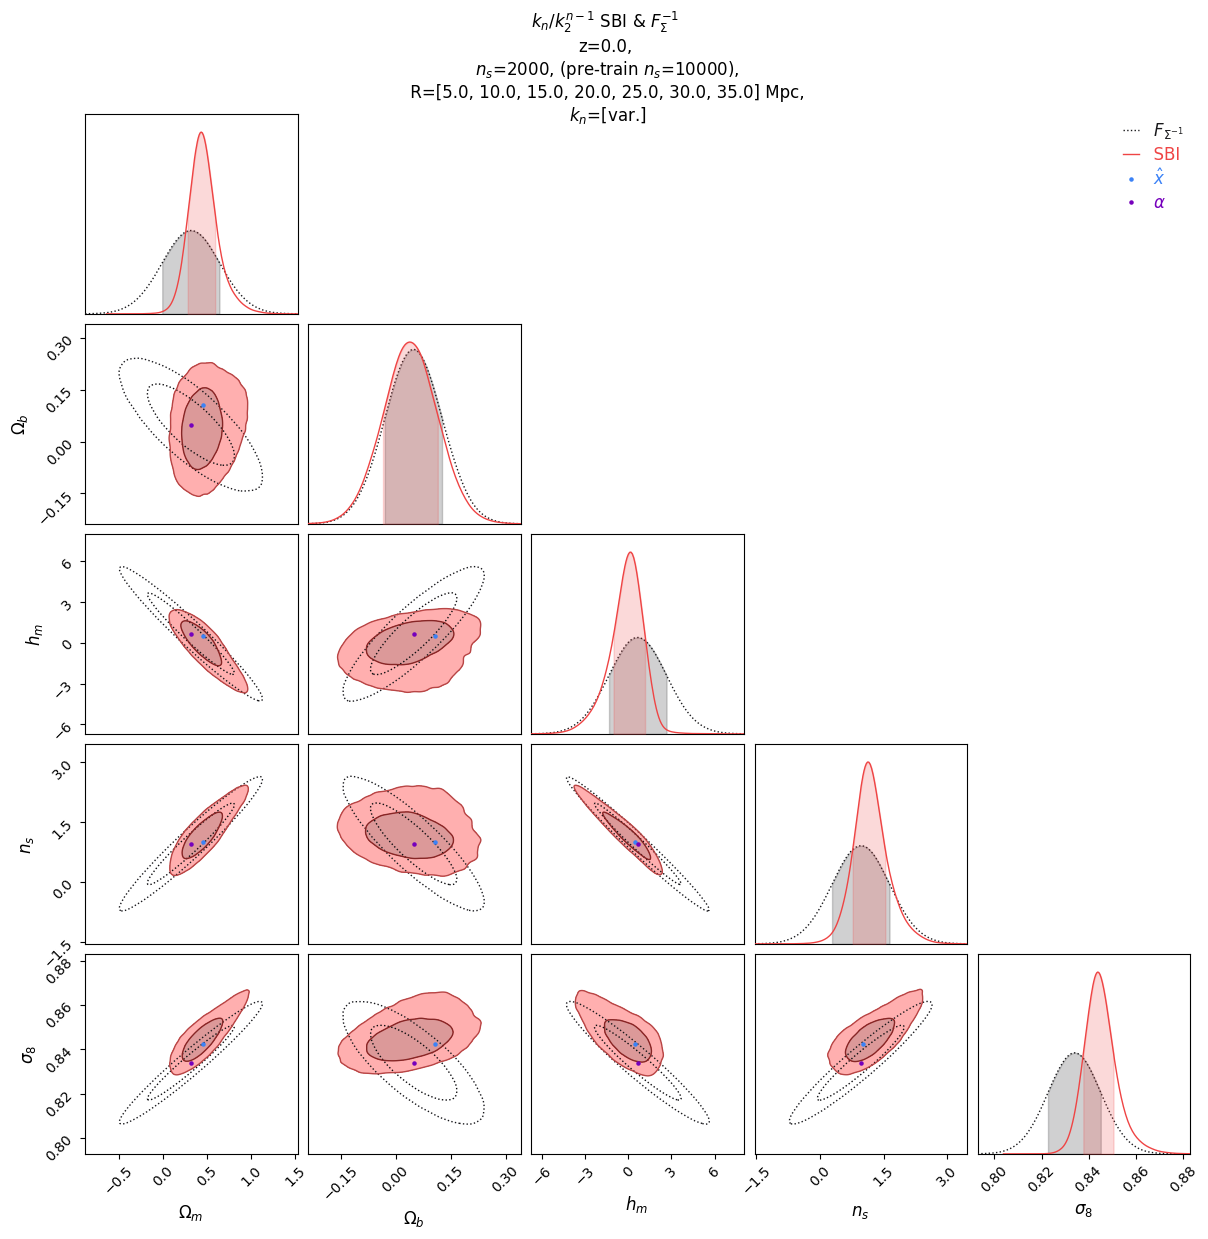

In [12]:
posterior_df = make_df(
    samples, 
    samples_log_prob, 
    parameter_strings=dataset.parameter_strings
)

c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(
        dataset.alpha,
        dataset.Finv,
        columns=dataset.parameter_strings,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        linestyle=":",
        shade_alpha=0.
    )
)
c.add_chain(Chain(samples=posterior_df, name="SBI", color="r"))
c.add_marker(
    location=marker(x_, parameter_strings=dataset.parameter_strings),
    name=r"$\hat{x}$", 
    color="b"
)
c.add_marker(
    location=marker(dataset.alpha, parameter_strings=dataset.parameter_strings),
    name=r"$\alpha$", 
    color="#7600bc"
)
fig = c.plotter.plot()
fig.suptitle(
    r"$k_n/k_2^{n-1}$ SBI & $F_{{\Sigma}}^{{-1}}$" + "\n" +
    "z={},\n $n_s$={}, (pre-train $n_s$={}),\n R={} Mpc,\n $k_n$={}".format(
            config.redshift, 
            len(X), 
            config.n_linear_sims if config.pre_train else None,
            "[{}]".format(", ".join(map(str, config.scales))),
            "[{}]".format(",".join(map(str, [["var.", "skew.", "kurt."][_] for _ in config.order_idx])))
        ),
    multialignment='center'
)
plt.show()
# plt.savefig(os.path.join(results_dir, "posterior_affine.pdf"))
# plt.savefig(os.path.join(posteriors_dir, "posterior_affine.pdf"))
# plt.close()